In [1]:
import pandas as pd
import csv
import glob
import os.path
import matplotlib.pyplot as plt
import seaborn as sns

## Read in the dataset and filter empty data

In [2]:
def insert_to_table(data: pd.DataFrame, table_name:str):
    db = create_engine(conn_string)
    conn = db.connect()
    data.to_sql(table_name, conn, if_exists="replace", index=False)
    conn.close()

In [3]:
def extract_from_csv(file_to_process: str) -> pd.DataFrame:
    with open(file_to_process, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)

    data = pd.read_csv(file_to_process)
    data = data.dropna(axis=1, how='all')
    extracted_data = pd.DataFrame(columns = header)
    extracted_data = pd.concat([extracted_data, data], ignore_index=True)
    return extracted_data

In [4]:
def filter_df(df: pd.DataFrame) -> pd.DataFrame:

    # drop empty cols
    # df = df.dropna(axis=1, how='all')

    # drop rows with only age and everything else null
    filtered_rows_index = df[~(df.drop(columns=['age']).isnull().all(axis=1) & ~df['age'].isnull())].index
    df = df.loc[filtered_rows_index]
    df['age'] = pd.to_numeric(df['age'], errors='coerce')


    # drop rows with all nan
    df = df[~df.isnull().all(axis=1)]

    return df

## Compute and analyze the various statistical measures

In [5]:
initial_df = extract_from_csv("./heart_disease.csv")
df = filter_df(initial_df)

/var/folders/z_/t4r4hcz97kv112dfhn64djl00000gn/T/ipykernel_25843/3615485252.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  extracted_data = pd.concat([extracted_data, data], ignore_index=True)


In [6]:
# first 5 rows of data
df.head(5)

,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,htn,chol,...,exeref,exerwm,thal,thalsev,thalpul,earlobe,cmo,cday,cyr,target
0,63.0,1.0,NaN,NaN,NaN,NaN,1.0,145.0,1.0,233.0,...,NaN,NaN,6.0,NaN,NaN,NaN,2.0,16.0,81.0,0.0
1,67.0,1.0,NaN,NaN,NaN,NaN,4.0,160.0,1.0,286.0,...,NaN,NaN,3.0,NaN,NaN,NaN,2.0,5.0,81.0,1.0
2,67.0,1.0,NaN,NaN,NaN,NaN,4.0,120.0,1.0,229.0,...,NaN,NaN,7.0,NaN,NaN,NaN,2.0,20.0,81.0,1.0
3,37.0,1.0,NaN,NaN,NaN,NaN,3.0,130.0,0.0,250.0,...,NaN,NaN,3.0,NaN,NaN,NaN,2.0,4.0,81.0,0.0
4,41.0,0.0,NaN,NaN,NaN,NaN,2.0,130.0,1.0,204.0,...,NaN,NaN,3.0,NaN,NaN,NaN,2.0,18.0,81.0,0.0


In [7]:
# Define the columns as numerical or categorical based on information from the dataset documentation

column_types = {
    'age': 'numerical', 
    'sex': 'categorical', 
    'painloc': 'categorical', 
    'painexer': 'categorical', 
    'relrest': 'categorical', 
    'pncaden': 'numerical', 
    'cp': 'categorical', 
    'trestbps': 'numerical', 
    'htn': 'categorical', 
    'chol': 'numerical', 
    'smoke': 'categorical', 
    'cigs': 'numerical', 
    'years': 'numerical', 
    'fbs': 'categorical', 
    'dm': 'categorical', 
    'famhist': 'categorical', 
    'restecg': 'categorical', 
    'ekgmo': 'categorical', 
    'ekgday': 'categorical', 
    'ekgyr': 'categorical', 
    'dig': 'categorical', 
    'prop': 'categorical', 
    'nitr': 'categorical', 
    'pro': 'categorical', 
    'diuretic': 'categorical', 
    'proto': 'categorical', 
    'thaldur': 'numerical', 
    'thaltime': 'numerical', 
    'met': 'numerical', 
    'thalach': 'numerical', 
    'thalrest': 'numerical', 
    'tpeakbps': 'numerical', 
    'tpeakbpd': 'numerical', 
    'dummy': 'numerical', 
    'trestbpd': 'numerical', 
    'exang': 'categorical', 
    'xhypo': 'categorical', 
    'oldpeak': 'numerical', 
    'slope': 'categorical', 
    'rldv5': 'numerical', 
    'rldv5e': 'numerical', 
    'ca': 'numerical', 
    'restckm': 'numerical', 
    'exerckm': 'numerical', 
    'restef': 'numerical', 
    'restwm': 'categorical', 
    'exeref': 'numerical', 
    'exerwm': 'categorical', 
    'thal': 'categorical', 
    'thalsev': 'numerical', 
    'thalpul': 'numerical', 
    'earlobe': 'numerical', 
    'cmo': 'categorical', 
    'cday': 'categorical', 
    'cyr': 'categorical', 
    'target': 'categorical'
}

cat_cols = [key for key, value in column_types.items() if value == 'categorical']
num_cols = [key for key, value in column_types.items() if value == 'numerical']

In [8]:
def get_info(df: pd.DataFrame):
    res = df.describe().transpose()
    print(res.shape)
    res['missing_percent'] = [(df.shape[0] - res.loc[ind, 'count'])/df.shape[0] for ind in res.index]
    res['unique_val'] = [len(df.loc[:,ind].value_counts()) for ind in res.index]
    res['var_type'] = res.index.map(column_types)
    
    csv_file_path = "data_info.csv"
    res.to_csv(csv_file_path)
    
    return res

In [9]:
info = get_info(df)
info

(54, 8)


,count,mean,std,min,25%,50%,75%,max,missing_percent,unique_val,var_type
age,899.0,53.480534,9.435894,28.00,47.0000,54.00,60.000,77.0,0.000000,50,numerical
sex,899.0,0.790879,0.406908,0.00,1.0000,1.00,1.000,1.0,0.000000,2,categorical
painloc,617.0,0.920583,0.270607,0.00,1.0000,1.00,1.000,1.0,0.313682,2,categorical
painexer,617.0,0.593193,0.491637,0.00,0.0000,1.00,1.000,1.0,0.313682,2,categorical
relrest,613.0,0.672104,0.469830,0.00,0.0000,1.00,1.000,1.0,0.318131,2,categorical
cp,899.0,3.253615,0.928499,1.00,3.0000,4.00,4.000,4.0,0.000000,4,categorical
trestbps,840.0,132.101190,19.151127,0.00,120.0000,130.00,140.000,200.0,0.065628,60,numerical
htn,865.0,0.476301,0.499727,0.00,0.0000,0.00,1.000,1.0,0.037820,2,categorical
chol,869.0,198.759494,111.834415,0.00,175.0000,224.00,269.000,603.0,0.033370,213,numerical
smoke,230.0,0.517391,0.500787,0.00,0.0000,1.00,1.000,1.0,0.744160,2,categorical


(54, 8)


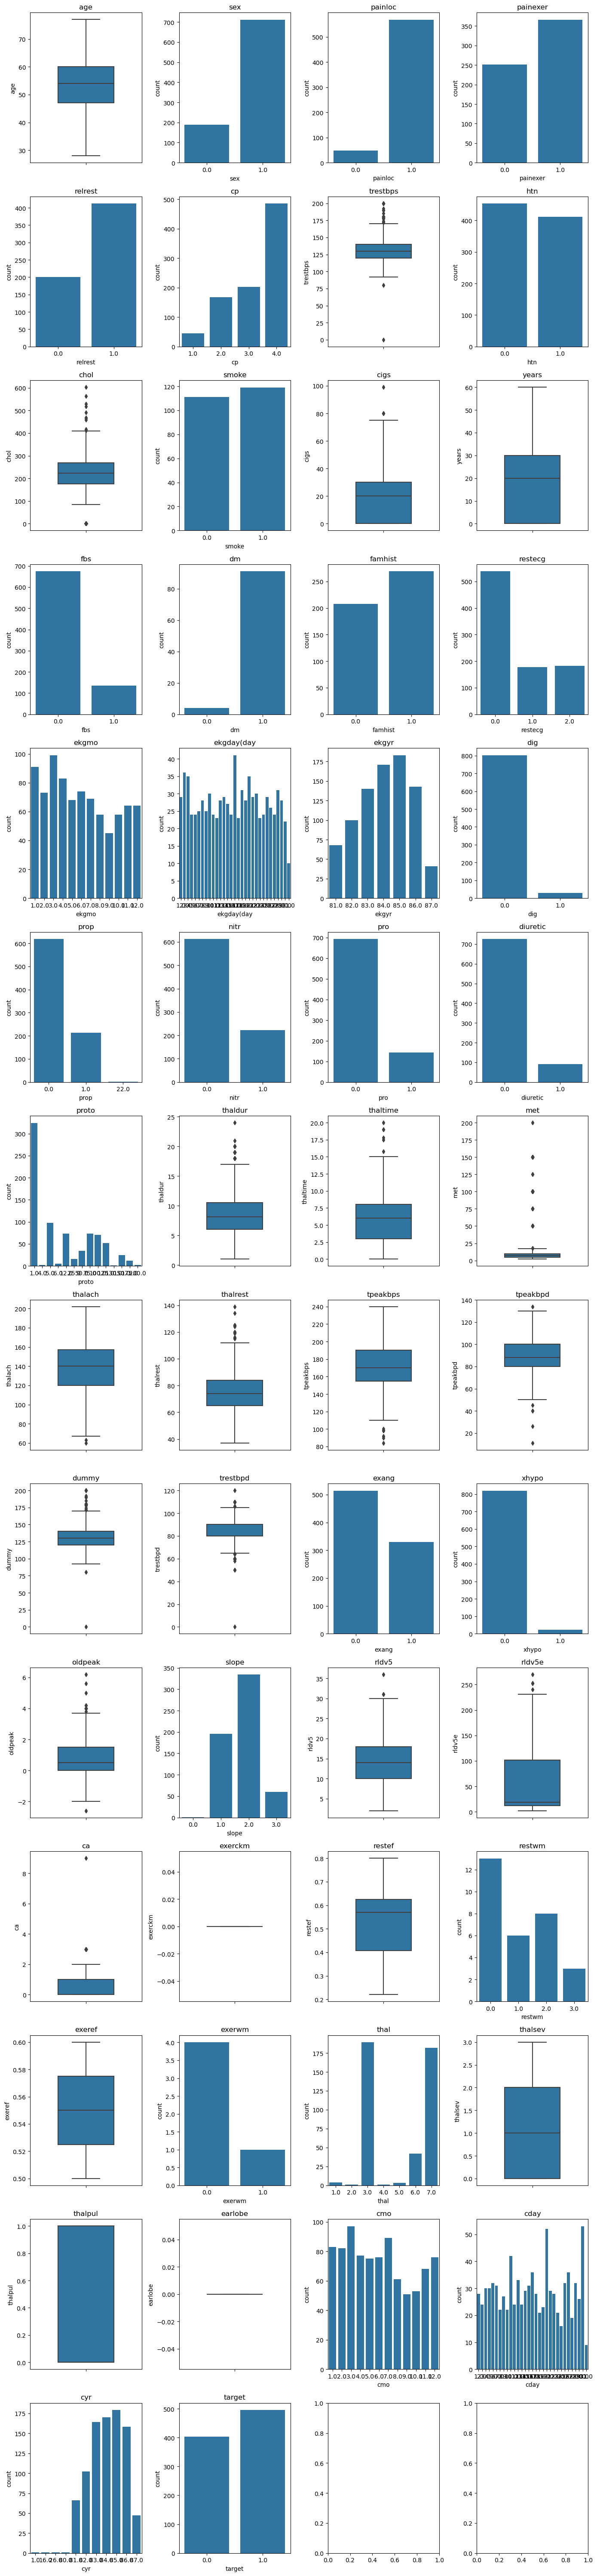

In [10]:
info = get_info(df)

fig,axs = plt.subplots(14,4,figsize=(14,60))

for i,ind in enumerate(info.index):

    if info.loc[ind, 'var_type'] == 'numerical':
        sns.boxplot(df,y=ind,ax=axs[i//4, i%4],width=0.5)
        

    else:
        sns.countplot(data=df,x=ind,color='#1f77b4',ax=axs[i//4, i%4])
    
    axs[i//4, i%4].set_title(ind)

fig.tight_layout()

### Missing values

There seem to be a lot of missing values from the columns.

In [ ]:
data_missing = (df.isnull().sum()/df.shape[0]).round(2)
data_missing[data_missing > 0]

## Analyze missing values and come up with a strategy to impute them. You might need different imputation methods for different features. Justify your choices.

In [ ]:
missing_indices = {}
for column in df.columns:
    missing_indices[column] = df.index[df[column].isna()].tolist()

# for column, indices in missing_indices.items():
#     print(f"Missing indices for column '{column}': {indices}")

# Create a heatmap of missing indices
plt.figure(figsize=(10, 6))
sns.heatmap(df.isna(), cmap='binary', cbar=False)
plt.title('Missing Values Heatmap')
plt.xlabel('Columns')
plt.ylabel('Indices')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [ ]:
# this column is supposed to be the sum of three pain values
df['pncaden'] = df[['painloc', 'painexer', 'relrest']].sum(axis=1)

The black bars show the missing values. There seem to be chunks of missing values for the most part.

In [ ]:
# filling the categorical values to be the mean of the others
df_filled = df

avg_cat_values = df_filled[cat_cols].mean()

df_filled[cat_cols] = df_filled[cat_cols].fillna(avg_cat_values)

# this column is supposed to be the sum of three pain values
df_filled['pncaden'] = df_filled[['painloc', 'painexer', 'relrest']].sum(axis=1)

In [ ]:
info_filled = get_info(df_filled)
info_filled

In [ ]:
# filling the numerical values to be the mode of the others
print(num_cols)
mode_num_values = df_filled[num_cols].mode().iloc[0]
print(mode_num_values)

df_filled[num_cols] = df_filled[num_cols].fillna(mode_num_values)


In [ ]:
info_filled = get_info(df_filled)
info_filled

## For the numerical features, identify outliers and appropriately deal with them. Justify your choices

In [11]:
# renaming ekgday(day to ekgday for consistency
df = df.rename(columns={'ekgday(day': 'ekgday'})

In [12]:
len(num_cols)

26

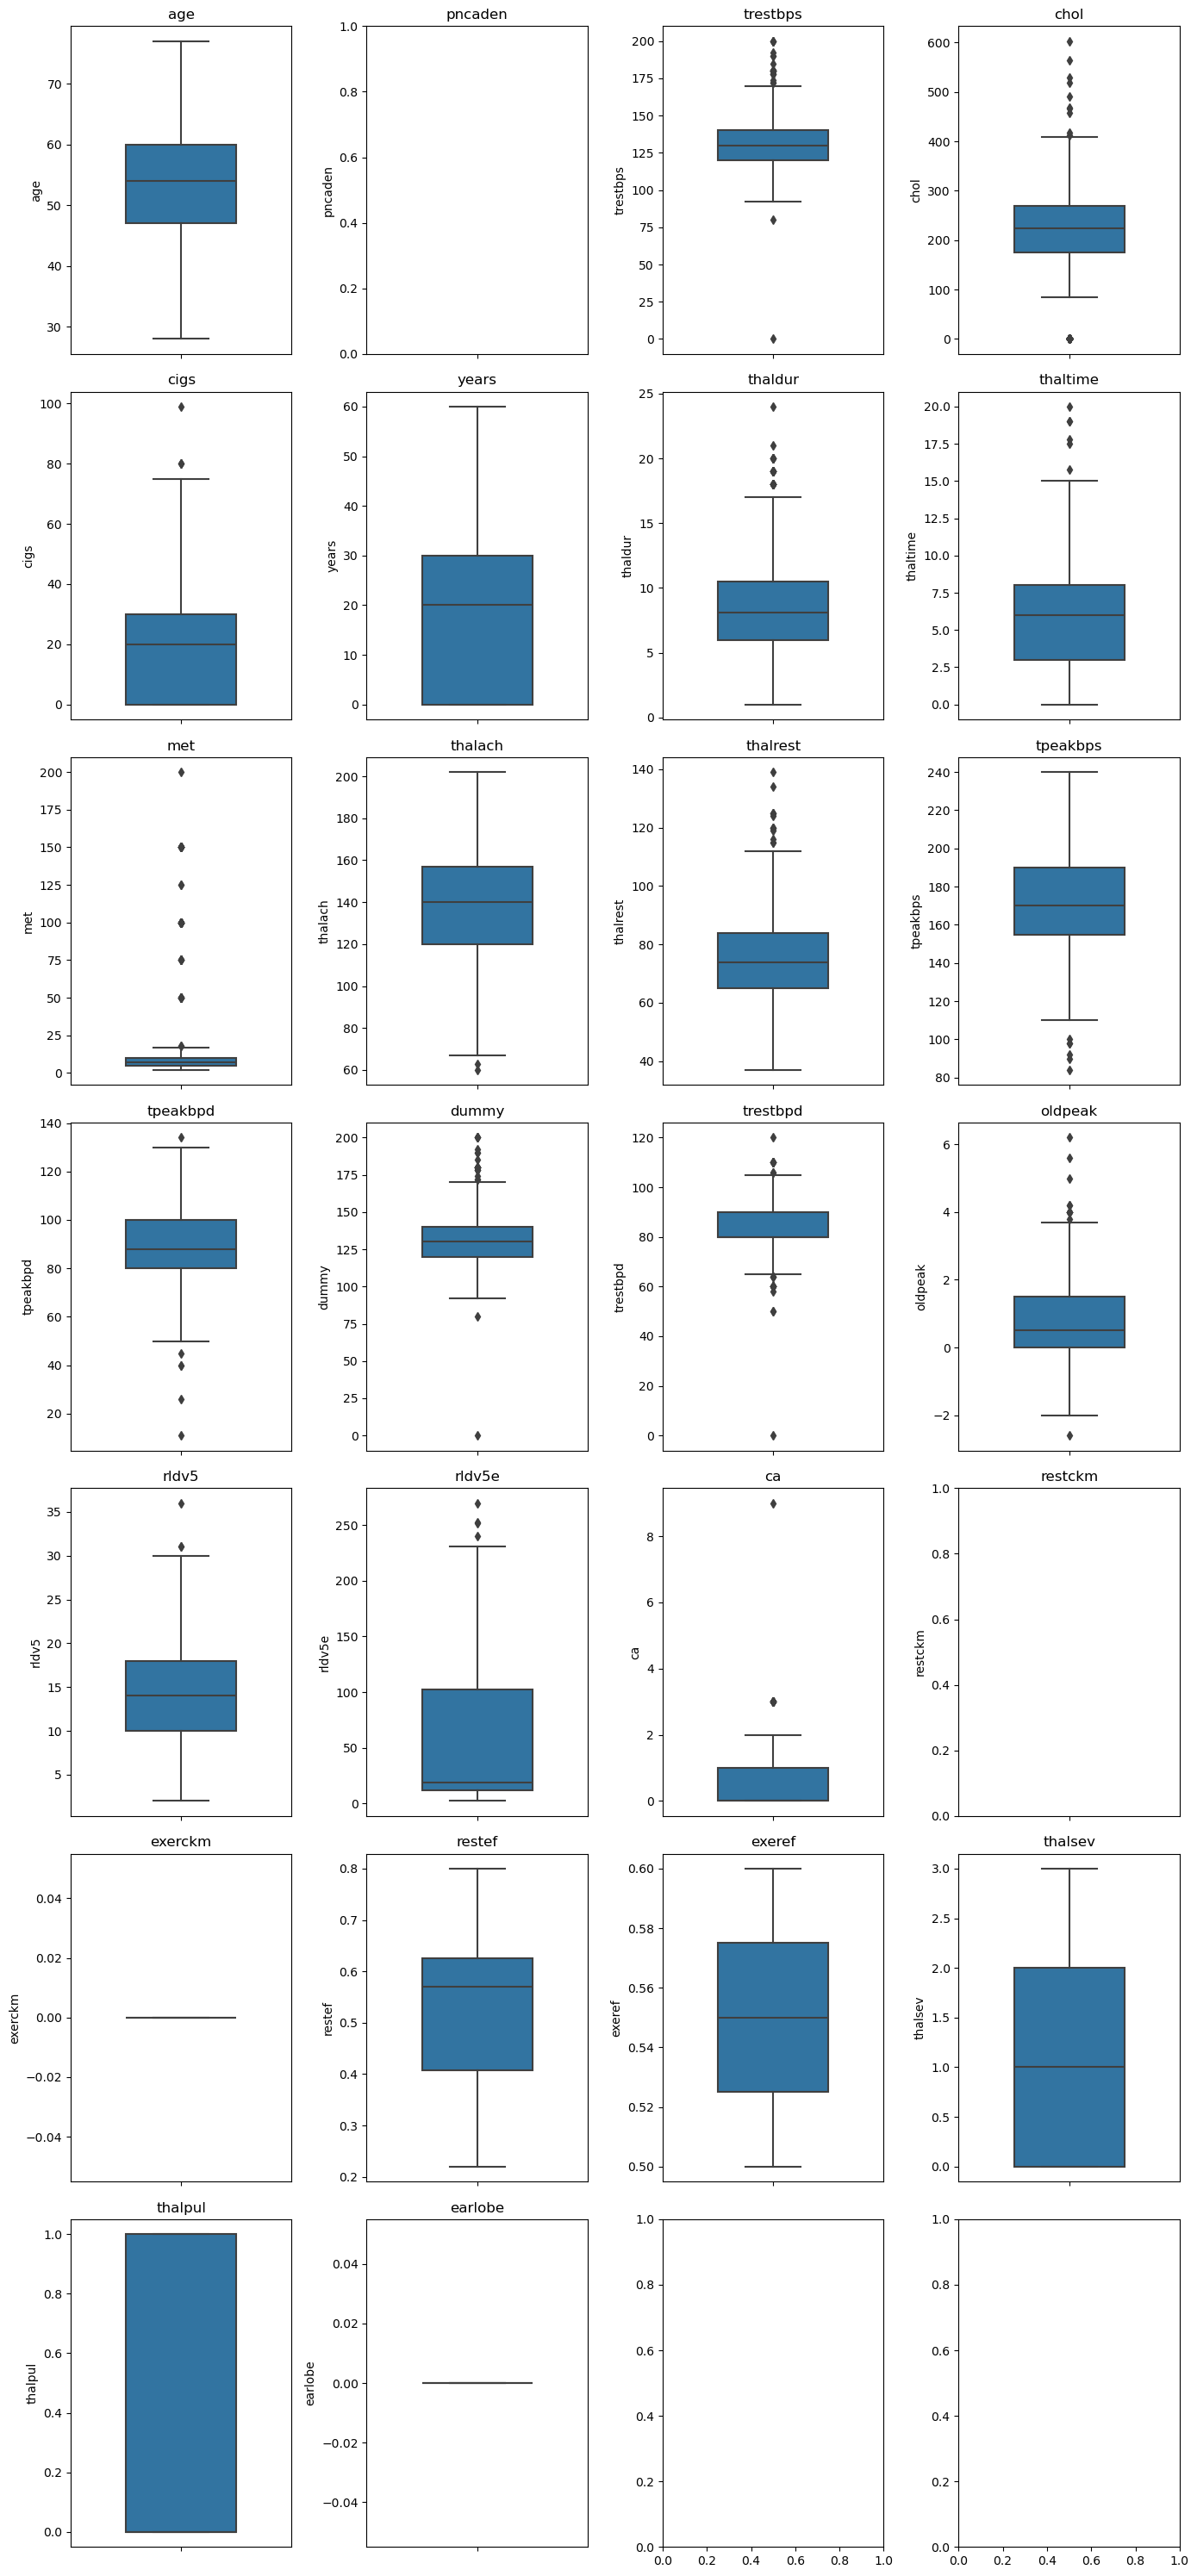

In [13]:
fig,axs = plt.subplots(7,4,figsize=(14,30))

for i,ind in enumerate(num_cols):

    sns.boxplot(df,y=ind,ax=axs[i//4, i%4],width=0.5)

    axs[i//4, i%4].set_title(ind)

fig.tight_layout()

In [14]:
for i,ind in enumerate(num_cols):

    print(i + 1, ": " + ind + "\n")

    mean = df[ind].mean()
    std = df[ind].std()

    outliers = df[ind][(df[ind] < (mean - 2 * std)) | (df[ind] > (mean + 2 * std))]
    print(outliers)
    print('-----------')


1 : age

101    34.0
132    29.0
161    77.0
225    34.0
233    74.0
257    76.0
305    74.0
313    77.0
357    75.0
372    75.0
403    74.0
407    76.0
419    74.0
422    75.0
455    74.0
470    74.0
517    32.0
538    31.0
549    32.0
558    32.0
589    34.0
597    33.0
601    34.0
608    34.0
653    29.0
686    31.0
691    28.0
698    30.0
702    29.0
706    33.0
750    34.0
754    32.0
777    32.0
796    34.0
798    74.0
858    73.0
Name: age, dtype: float64
-----------
2 : pncaden

Series([], Name: pncaden, dtype: object)
-----------
3 : trestbps

14     172.0
83     180.0
126    200.0
172    174.0
183    178.0
188    192.0
201    180.0
213    178.0
231    180.0
289    180.0
315      0.0
341    178.0
416    172.0
451    180.0
458    190.0
591    190.0
605    180.0
672    180.0
673    180.0
710     92.0
724    200.0
757    180.0
758    180.0
761    180.0
797     80.0
848    200.0
855    185.0
882    200.0
894    180.0
Name: trestbps, dtype: float64
-----------
4 : chol

152    564.

Outliers:
1. age : N/A
2. pncaden : N/A (all NaN)
3. trestbps : high values might be an indicator of heart disease
               0 I will CHANGE to NaN because 0 is impossible
4. chol : high values might be an indicator of heart disease
5. cigs : high values might be an indicator of heart disease
6. years : high values might be an indicator of heart disease
7. thaldur : high values might be an indicator of GOOD HEART, low values might be an indicator of heart disease
8. thaltime: outliers might be bad 
9.met: mets achieved... not sure, but keep note of outliers
10. thalach : maximum heart rate achieved, outliers on both sides could be abnormal
11. thalrest : resting heart rate, outliers on both sides could be abnormal
12. tpeakbps : peak blood pressure 1, note outliers
13. tpeakbpd : peak blood pressure 1, note outliers
14. dummy : ignore, will delete this col
15. trestbpd : resting blood pressure, note outliers
16. oldpeak : ST depression induced by exercise relative to rest, note
17. rldv5 : height at rest, note
18.  rldv5 e: height at peak exercis, note
19. ca : number of major vessels (0-3) colored by flourosopy, note the outliers, change 9 to NaN
20. restckm : N/A
21. exerckm : N/A
22. restef : 1 outlier, doesn't seem that important
23. exeref : N/A
24. thalsev : N/A
25. thalpul : N/A
26. earlobe : N/A
 

In [15]:
for i,ind in enumerate(num_cols):

    print(ind + "\n")

    mean = df[ind].mean()
    std = df[ind].std()

    outliers_3 = df[ind][(df[ind] < (mean - 3 * std)) | (df[ind] > (mean + 3 * std))]
    print(outliers_3)
    print('-----------')

age

Series([], Name: age, dtype: float64)
-----------
pncaden

Series([], Name: pncaden, dtype: object)
-----------
trestbps

126    200.0
188    192.0
315      0.0
458    190.0
591    190.0
724    200.0
848    200.0
882    200.0
Name: trestbps, dtype: float64
-----------
chol

152    564.0
631    603.0
Name: chol, dtype: float64
-----------
cigs

10     75.0
39     99.0
74     80.0
263    80.0
323    80.0
Name: cigs, dtype: float64
-----------
years

Series([], Name: years, dtype: float64)
-----------
thaldur

507    21.0
529    20.0
540    20.0
601    24.0
691    20.0
702    20.0
711    20.0
718    20.0
Name: thaldur, dtype: float64
-----------
thaltime

540    19.0
718    19.0
748    20.0
783    17.8
Name: thaltime, dtype: float64
-----------
met

828    150.0
830    150.0
834    150.0
835    150.0
837    150.0
840    125.0
842    150.0
846    150.0
847    150.0
859    150.0
862    200.0
864    150.0
865    150.0
867    150.0
868    150.0
875    125.0
877    150.0
878    150.0
880 

With 3 stds, more specific

In [16]:
df = df.drop(columns=['dummy'])

In [17]:
column_types.pop('dummy')

'numerical'

In [18]:
num_cols.remove('dummy')

In [19]:
df.loc[df['trestbps'] == 0, 'trestbps'] = float('nan')
df.loc[df['ca'] == 9, 'ca'] = float('nan')

I changed the outliers that seemed like incorrect information, but the others will be important for determining who is susceptible to heart disease in the future.

## Feature transformations

In [20]:
cat_cols

['sex',
 'painloc',
 'painexer',
 'relrest',
 'cp',
 'htn',
 'smoke',
 'fbs',
 'dm',
 'famhist',
 'restecg',
 'ekgmo',
 'ekgday',
 'ekgyr',
 'dig',
 'prop',
 'nitr',
 'pro',
 'diuretic',
 'proto',
 'exang',
 'xhypo',
 'slope',
 'restwm',
 'exerwm',
 'thal',
 'cmo',
 'cday',
 'cyr',
 'target']

Decording the numeric categories for all the categorical features to make the graphs easier to understand.

In [21]:
df_feature_trans = df
df_feature_trans['sex'] = (
    df_feature_trans['sex']
    .replace({0:'female',1:'male'})
    .astype('category'))

df_feature_trans['painloc'] = (
    df_feature_trans['painloc']
    .replace({0:'otherwise',1:'substernal'})
    .astype('category'))

df_feature_trans['painexer'] = (
    df_feature_trans['painexer']
    .replace({0:'otherwise',1:'provoked by exertion'})
    .astype('category'))

df_feature_trans['relrest'] = (
    df_feature_trans['relrest']
    .replace({0:'otherwise',1:'relieved after rest'})
    .astype('category'))

df_feature_trans['cp'] = (
    df_feature_trans['cp']
    .replace({1:'typical angina',2:'atypical angina',3:'non-anginal pain',4:'asymptomatic'})
    .astype('category'))

df_feature_trans['smoke'] = (
    df_feature_trans['smoke']
    .replace({0:'no',1:'yes'})
    .astype('category'))

df_feature_trans['fbs'] = (
    df_feature_trans['fbs']
    .replace({0:'fbs less than or equal to 120',1:'fbs greater than 120'})
    .astype('category'))

df_feature_trans['dm'] = (
    df_feature_trans['dm']
    .replace({0:'no history of diabetes',1:'history of diabetes'})
    .astype('category'))

df_feature_trans['famhist'] = (
    df_feature_trans['famhist']
    .replace({0:'no',1:'yes'})
    .astype('category'))
df_feature_trans = df_feature_trans.rename(columns={'famhist': 'family_history_of_coronary_artery_disease'})
column_types['family_history_of_coronary_artery_disease'] = column_types.pop('famhist')


df_feature_trans['restecg'] = (
    df_feature_trans['restecg']
    .replace({0:'normal',1:'having ST-T wave abnormality',2:'showing probable or definite left ventricular hypertrophy'})
    .astype('category'))

df_feature_trans['ekgmo'] = (
    df_feature_trans['ekgmo']
    .replace({1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
              7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'})
    .astype('category'))

df_feature_trans['dig'] = (
    df_feature_trans['dig']
    .replace({0:'no',1:'yes'})
    .astype('category'))
df_feature_trans = df_feature_trans.rename(columns={'dig': 'digitalis_used_during_exercise'})
column_types['digitalis_used_during_exercise'] = column_types.pop('dig')

df_feature_trans['prop'] = (
    df_feature_trans['prop']
    .replace({0:'no',1:'yes'})
    .astype('category'))
df_feature_trans = df_feature_trans.rename(columns={'prop': 'Beta_blocker_used_during_exercise'})
column_types['Beta_blocker_used_during_exercise'] = column_types.pop('prop')

df_feature_trans['nitr'] = (
    df_feature_trans['nitr']
    .replace({0:'no',1:'yes'})
    .astype('category'))
df_feature_trans = df_feature_trans.rename(columns={'nitr': 'nitrates_used_during_exercise_ECG'})
column_types['nitrates_used_during_exercise_ECG'] = column_types.pop('nitr')

df_feature_trans['pro'] = (
    df_feature_trans['pro']
    .replace({0:'no',1:'yes'})
    .astype('category'))
df_feature_trans = df_feature_trans.rename(columns={'pro': 'calcium_channel_blocker_used_during_exercise_ECG'})
column_types['calcium_channel_blocker_used_during_exercise_ECG'] = column_types.pop('pro')

df_feature_trans['diuretic'] = (
    df_feature_trans['diuretic']
    .replace({0:'no',1:'yes'})
    .astype('category'))
df_feature_trans = df_feature_trans.rename(columns={'diuretic': 'diuretic_used_during_exercise_ECG'})
column_types['diuretic_used_during_exercise_ECG'] = column_types.pop('diuretic')

df_feature_trans['proto'] = (
    df_feature_trans['proto']
    .replace({1: 'Bruce', 2: 'Kottus', 3: 'McHenry', 4: 'fast Balke', 5: 'Balke', 6: 'Noughton',
              7: 'bike 150 kpa min/min', 8: 'bike 125 kpa min/min', 9: 'bike 100 kpa min/min',
              10: 'bike 75 kpa min/min', 11: 'bike 50 kpa min/min', 12: 'arm ergometer', 0: 'no', 1: 'yes'})
    .astype('category'))

df_feature_trans['exang'] = (
    df_feature_trans['exang']
    .replace({0:'no',1:'yes'})
    .astype('category'))
df_feature_trans = df_feature_trans.rename(columns={'exang': 'exerise_induced_angina'})
column_types['exerise_induced_angina'] = column_types.pop('exang')

df_feature_trans['xhypo'] = (
    df_feature_trans['xhypo']
    .replace({0:'no',1:'yes'})
    .astype('category'))

df_feature_trans['slope'] = (
    df_feature_trans['slope']
    .replace({1:'upsloping',2:'flat',3:'downsloping'})
    .astype('category'))
df_feature_trans = df_feature_trans.rename(columns={'slope': 'slope_peak_ex_ST_segment'})
column_types['slope_peak_ex_ST_segment'] = column_types.pop('slope')

df_feature_trans['restwm'] = (
    df_feature_trans['restwm']
    .replace({0:'none',1:'mild or moderate',2:'moderate or severe',3:'akinesis or dyskmem'})
    .astype('category'))

df_feature_trans['exerwm'] = (
    df_feature_trans['exerwm']
    .replace({0:'none',1:'mild or moderate',2:'moderate or severe',3:'akinesis or dyskmem'})
    .astype('category'))

df_feature_trans['thal'] = (
    df_feature_trans['thal']
    .replace({3:'normal',6:'fixed defect',7:'reversable defect'})
    .astype('category'))


df_feature_trans['cmo'] = (
    df_feature_trans['cmo']
    .replace({1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
              7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'})
    .astype('category'))

df_feature_trans['target_label'] = (
    df_feature_trans['target']
    .replace({0:'< 50% diameter narrowing',1:'> 50% diameter narrowing'})
    .astype('category'))

df_feature_trans

,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,htn,chol,...,exerwm,thal,thalsev,thalpul,earlobe,cmo,cday,cyr,target,target_label
0,63.0,male,NaN,NaN,NaN,NaN,typical angina,145.0,1.0,233.0,...,NaN,fixed defect,NaN,NaN,NaN,February,16.0,81.0,0.0,< 50% diameter narrowing
1,67.0,male,NaN,NaN,NaN,NaN,asymptomatic,160.0,1.0,286.0,...,NaN,normal,NaN,NaN,NaN,February,5.0,81.0,1.0,> 50% diameter narrowing
2,67.0,male,NaN,NaN,NaN,NaN,asymptomatic,120.0,1.0,229.0,...,NaN,reversable defect,NaN,NaN,NaN,February,20.0,81.0,1.0,> 50% diameter narrowing
3,37.0,male,NaN,NaN,NaN,NaN,non-anginal pain,130.0,0.0,250.0,...,NaN,normal,NaN,NaN,NaN,February,4.0,81.0,0.0,< 50% diameter narrowing
4,41.0,female,NaN,NaN,NaN,NaN,atypical angina,130.0,1.0,204.0,...,NaN,normal,NaN,NaN,NaN,February,18.0,81.0,0.0,< 50% diameter narrowing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,54.0,male,substernal,provoked by exertion,relieved after rest,NaN,asymptomatic,180.0,0.0,0.0,...,NaN,reversable defect,1.0,0.0,NaN,May,7.0,85.0,1.0,> 50% diameter narrowing
895,56.0,male,substernal,provoked by exertion,relieved after rest,NaN,asymptomatic,125.0,0.0,0.0,...,NaN,reversable defect,2.0,0.0,NaN,June,20.0,85.0,1.0,> 50% diameter narrowing
896,56.0,male,otherwise,provoked by exertion,relieved after rest,NaN,non-anginal pain,125.0,0.0,0.0,...,NaN,reversable defect,1.0,0.0,NaN,June,25.0,85.0,1.0,> 50% diameter narrowing
897,54.0,male,substernal,provoked by exertion,relieved after rest,NaN,asymptomatic,130.0,0.0,0.0,...,NaN,reversable defect,2.0,0.0,NaN,July,4.0,85.0,1.0,> 50% diameter narrowing


## Final plots

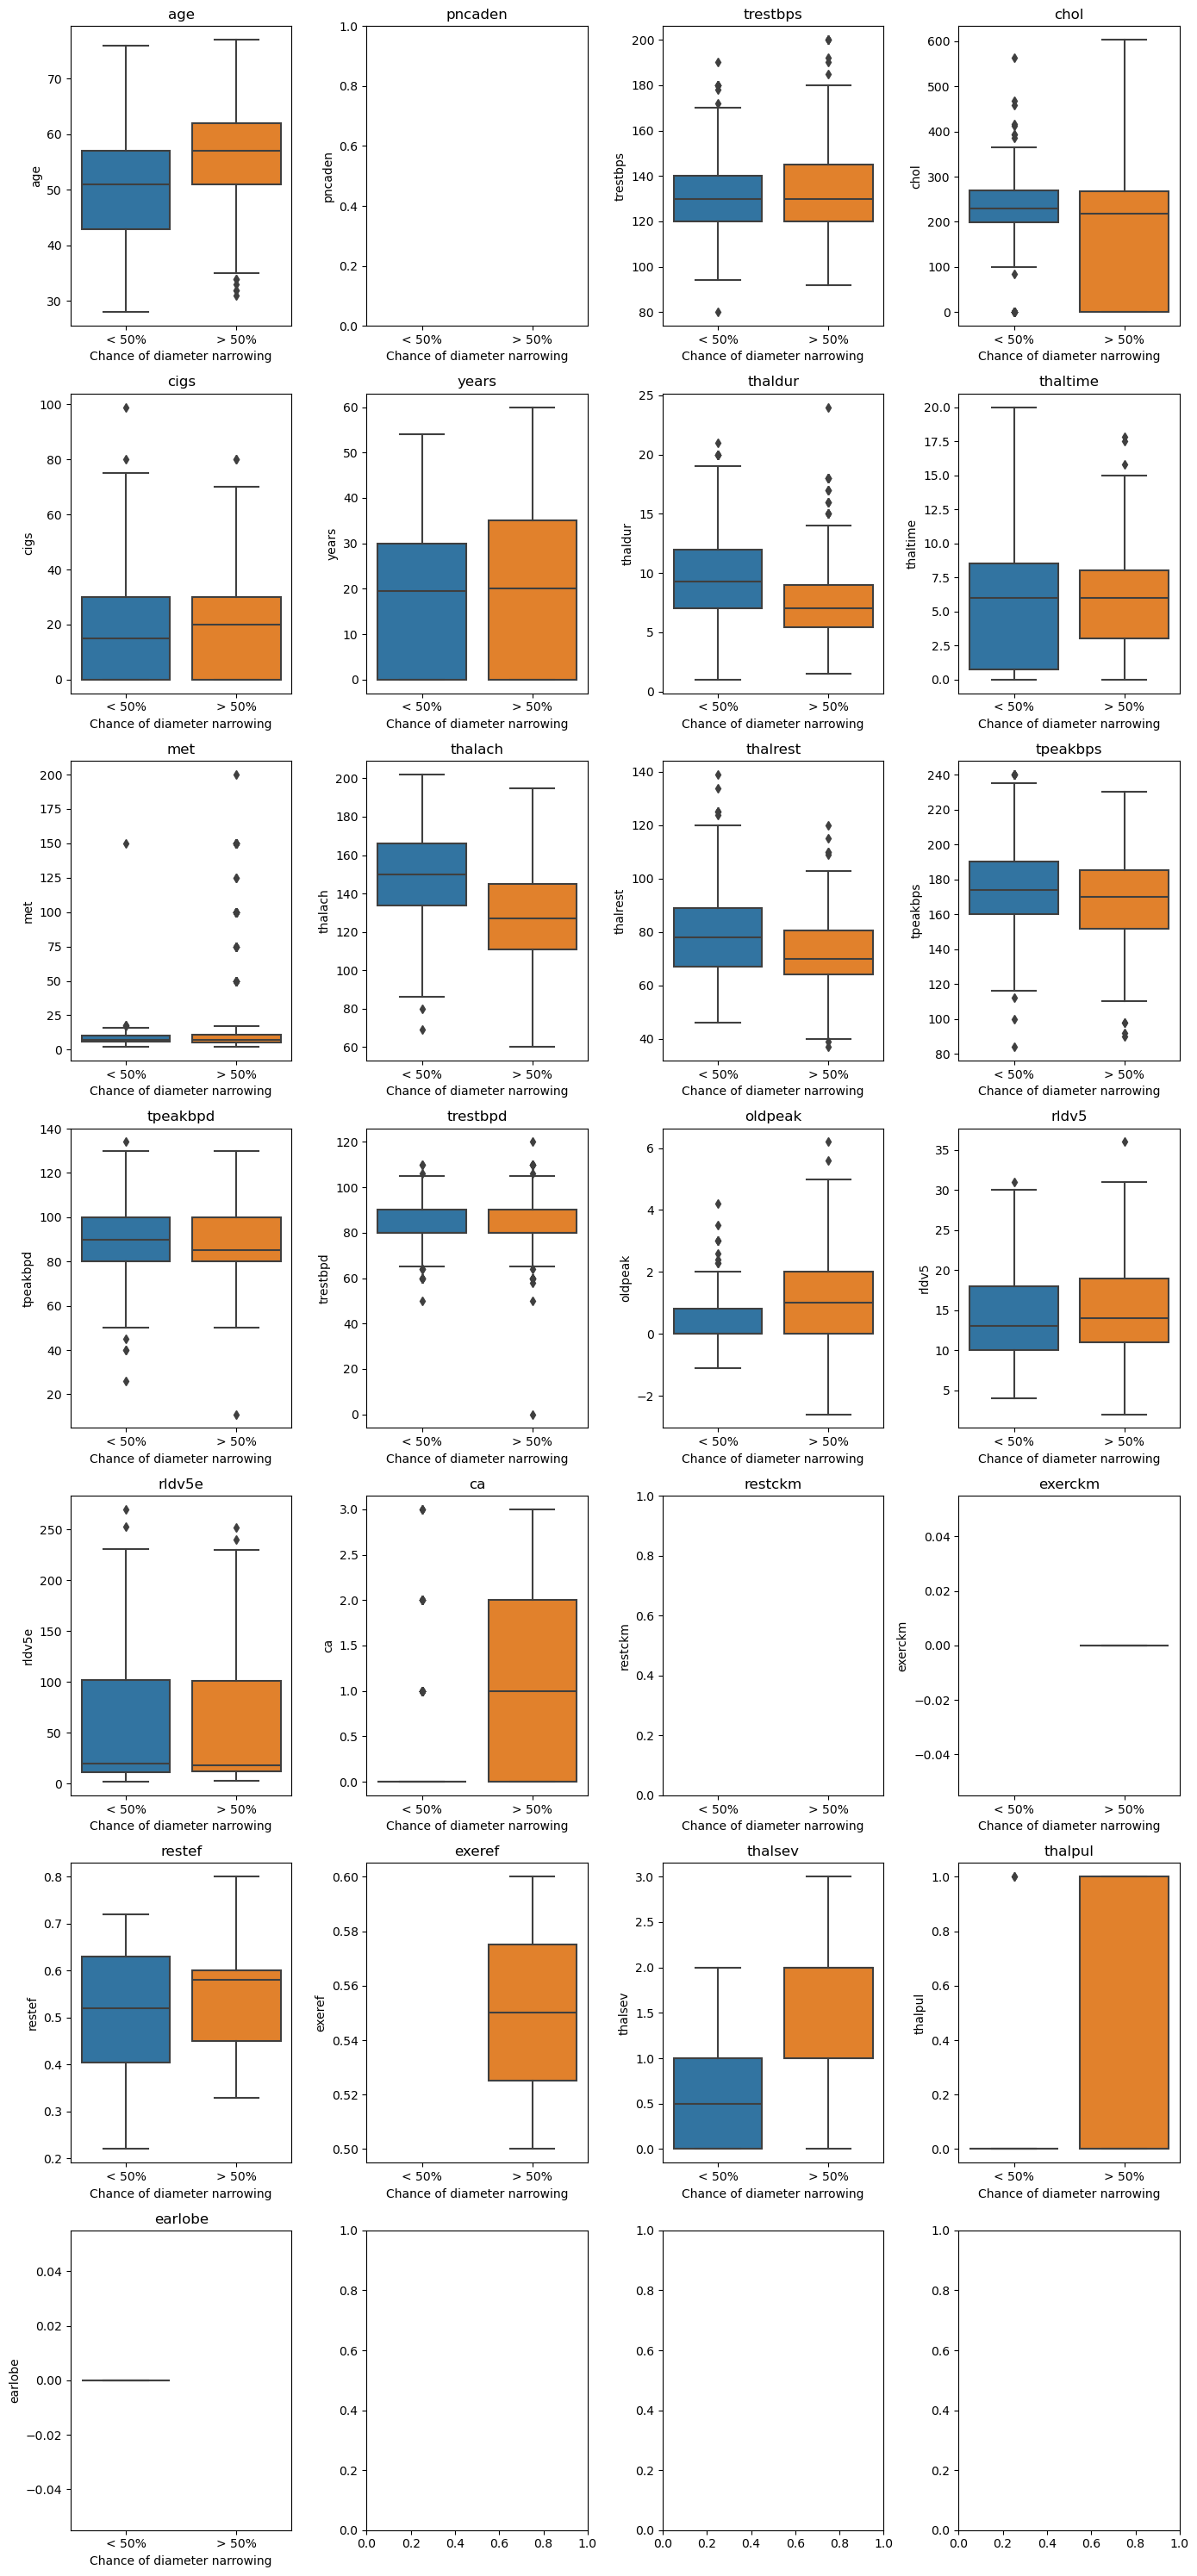

In [27]:
# df = df_feature_trans

fig,axs = plt.subplots(7,4,figsize=(14,30))

for i,ind in enumerate(num_cols):

    sns.boxplot(data=df_feature_trans, x='target', y=ind, ax=axs[i//4, i%4])

    axs[i//4, i%4].set_title(ind)
    axs[i//4, i%4].set_xticklabels(['< 50%', '> 50%'])
    axs[i//4, i%4].set_xlabel('Chance of diameter narrowing')


fig.tight_layout()



/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning

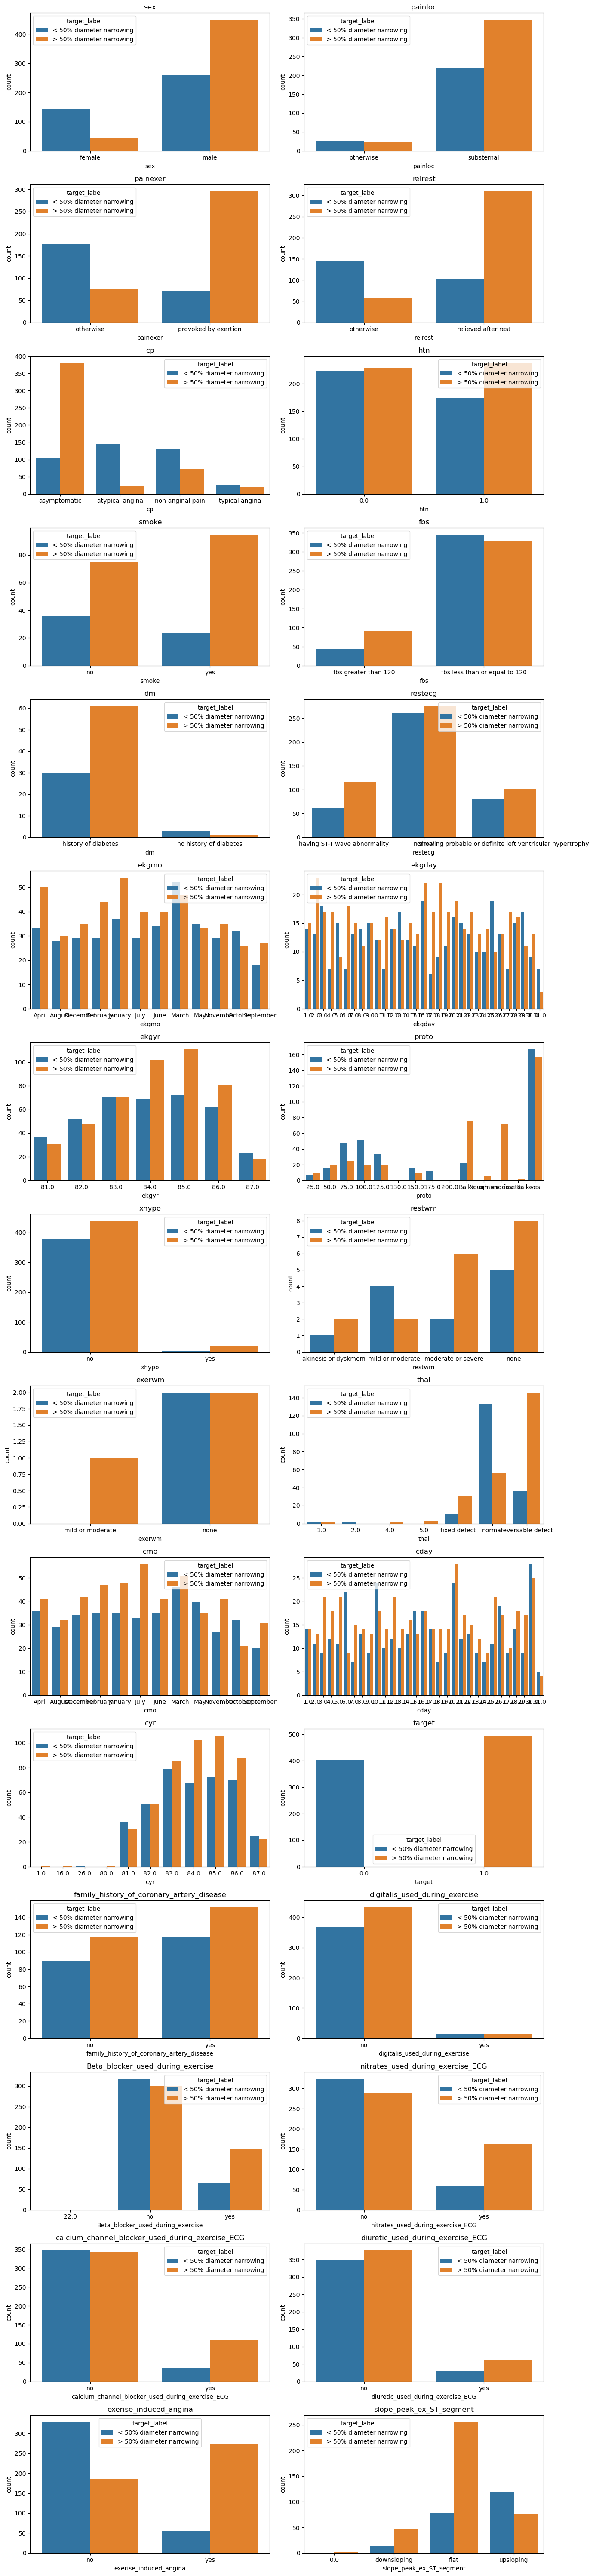

In [23]:
cat_cols = [key for key, value in column_types.items() if value == 'categorical']

fig,axs = plt.subplots(15,2,figsize=(14,60))

for i,ind in enumerate(cat_cols):
    grouped_data = df_feature_trans.groupby([ind, 'target_label'], observed=False).size().reset_index(name='count')
    sns.barplot(data=grouped_data, x=ind, y='count', hue='target_label', ax=axs[i//2, i%2])
    # plt.title('Comparison of Two Boolean Values')
    # plt.xlabel('Boolean Value 1')
    # plt.ylabel('Count')
    axs[i//2, i%2].set_title(ind)
fig.tight_layout()
